## Enriching High-order topologies

Depending on the problem at hand, it might be necessary to integrate additional information to the (pairwise/high-order) network structure, e.g., demographic information, opinions, psycholinguistic features, etc.
Often, this is done via node attributes, i.e., features that are attached to individual nodes.




In [1]:
!pip install hypergraphx==1.7.3

zsh:1: command not found: pip


First, let's download the data and load a sample hypergraph

In [2]:
# !wget -qO - https://raw.githubusercontent.com/andreafailla/andreafailla.github.io/main/static/uploads/data/icwsm2025.tar.gz | tar -xzv
!curl -L https://raw.githubusercontent.com/andreafailla/andreafailla.github.io/main/static/uploads/data/icwsm2025.tar.gz | tar -xzv


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0x icwsm2025/
x icwsm2025/.DS_Store
x icwsm2025/minorities-labels.csv
x icwsm2025/politics-edges.txt
x icwsm2025/politics-labels.csv
x icwsm2025/guncontrol-edges.txt
100  102k  100  102k    0     0   132k      0 --:--:-- --:--:-- --:--:--  132k

x icwsm2025/sample.json
x icwsm2025/guncontrol-labels.csv


In [3]:
import hypergraphx as hgx
from hypergraphx.readwrite.load import load_hypergraph

h = load_hypergraph('icwsm2025/sample.json', file_type='json')

We will randomly add a categorical and a numerical attribute to each node with the dedicated method

In [4]:
import numpy as np

for n in h.get_nodes():

    # draw leaning from distribution
    leaning_distr = [0.25, 0.25, 0.5]
    l = str(np.random.choice(['L', 'R', 'N'], p=leaning_distr))

    # draw age from a normal distribution
    mean = (18 + 30) / 2
    std_dev = (30 - 18) / 6  # Rough estimation for std dev: range / 6 (empirical rule)
    age = int(np.random.normal(mean, std_dev))

    h.set_meta(n,
        {
        'leaning': l,
        'age': age
        }
    )

To obtain metadata info for a node:

In [5]:
attrs_1 = h.get_meta(1)
attrs_1

{'leaning': 'N', 'age': 22}

To get all node metedata:

In [6]:
metadata = {n: h.get_meta(n) for n in h.get_nodes()}

Let's visualize the distribution of node attributes

In [7]:
import matplotlib.pyplot as plt

def plot_attributes_distribution(h, attr_name):
    counts = dict()

    for n in h.get_nodes():
        a = h.get_meta(n)
        attr = a.get(attr_name)
        if attr not in counts:
            counts[attr] = 0
        counts[attr] += 1

    categorical = isinstance(list(counts.keys())[0], str)

    if categorical:
        plt.barh(counts.keys(), counts.values())
        plt.xlabel("Count")
    else:
        plt.hist(counts.keys(), weights=counts.values(), bins=10)
        plt.ylabel("Count")
    plt.title(f"{attr_name} distribution")
    plt.show()

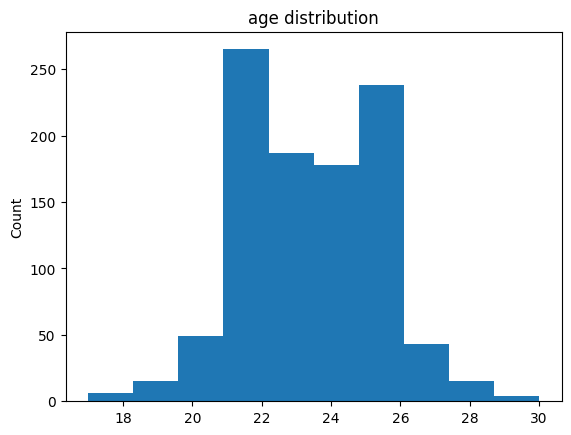

In [8]:
plot_attributes_distribution(h, 'age')

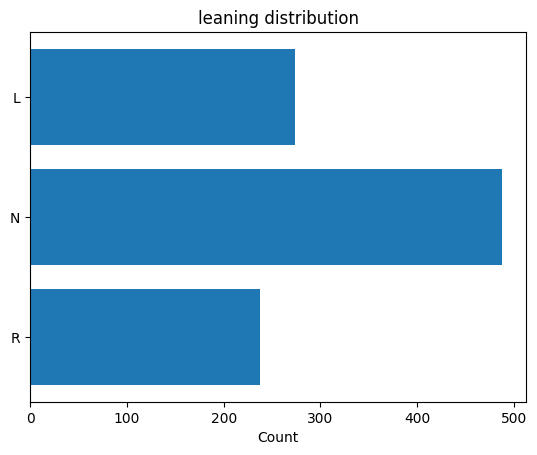

In [9]:
plot_attributes_distribution(h, 'leaning')

When working with node-attributed hypernetwork structures, we can quantify how homogeneous the nodes are within a certain hyperedge. In the case of social hypernetworks, for instance, this can give an idea of the homophilic tendencies of the population.

`Hypergraphx` does not directly provide utilities/measures to work with node-attributed hypernetworks, but we can write a simple function that computes the most frequent node attribute value within a set of nodes.


In [10]:
from collections import Counter

def purity(h, edge, attr_name='attr'):
    """
    Compute the purity of an edge.
    Returns the most frequent attribute value and its relative frequency.
    """
    edge_attrs = [h.get_meta(n).get(attr_name) for n in edge]
    c = Counter(edge_attrs)
    most_freq_att_val = c.most_common(1)[0][0]
    purity = c.most_common(1)[0][1] / len(edge_attrs)
    return most_freq_att_val, purity


def plot_kde(distribution, xlabel, by_label=False):
    purity_df = pd.DataFrame(distribution, columns=['Label', 'Val'])

    plt.figure(figsize=(8, 6))
    if by_label: # if aggregating by label, set hue colors according to labels
        hue = 'Label'
    else:
        hue = None

    # Plot univariate or bivariate distributions using kernel density estimation.
    # A kernel density estimate (KDE) plot is a method for visualizing
    # the distribution of observations in a dataset, analogous to a histogram.
    # KDE represents the data using a continuous probability density curve
    # in one or more dimensions.
    sns.kdeplot(
        data=purity_df,
        x='Val',
        hue=hue,
        fill=True,
        common_norm=True,
        alpha=.3
    )

    plt.xlim(0,1)
    plt.xlabel(xlabel)
    plt.ylabel('Density')
    plt.show()

In [11]:
edge =  (315, 417, 486, 516, 631)
print('edge:', edge)
print('leaning:', [h.get_meta(n)['leaning'] for n in edge])
print('purity:', purity(h, edge, attr_name='leaning'))

edge: (315, 417, 486, 516, 631)
leaning: ['N', 'L', 'L', 'N', 'N']
purity: ('N', 0.6)


Let's compute the purities for all hyperedges as follows:

In [12]:
purities = []
for edge in h.get_edges():
    res = purity(h, edge, attr_name='leaning')
    purities.append(res)

Then, we can use the function we defined earlier to visualize the score distribution.

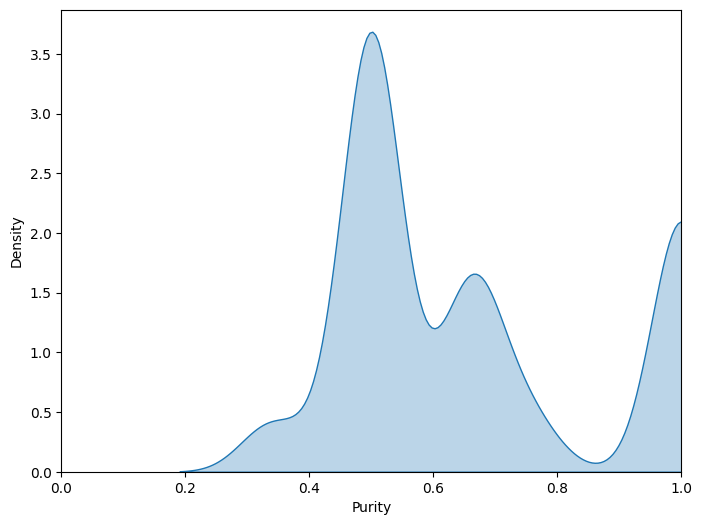

In [13]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
plot_kde(purities, 'Purity')

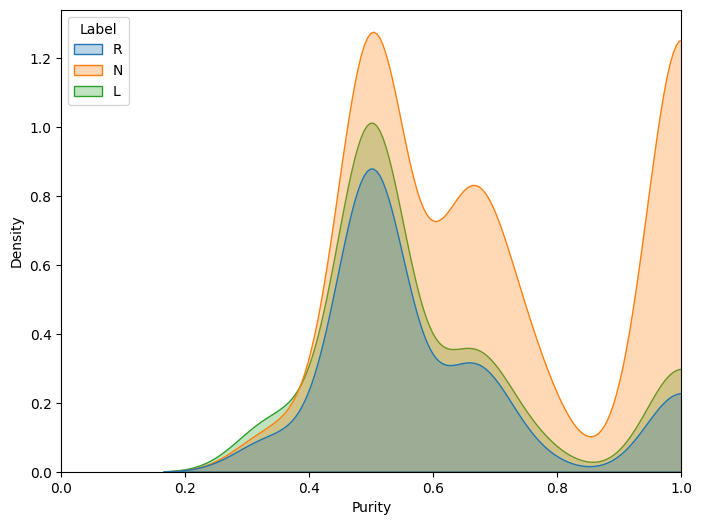

In [14]:
plot_kde(purities, 'Purity', by_label=True)

Especially in social hypergraphs, we might be interested in quantifying how much an individual is embedded in like-minded contexts.
To do so, we can:
- select a target node $u$
- look at its incident hyperedges (contexts)
- label each context with the predominant opinion
- compute the relative frequency of $u$'s attribute over the context labels

This measure was introduced in [1] as *Star Homogeneity*.

> *Failla, A., Citraro, S., & Rossetti, G. (2023). Attributed Stream Hypergraphs: temporal modeling of node-attributed high-order interactions. Applied Network Science, 8(1), 31.*

In [15]:
def star_homogeneity(h, node, attr_name='attr'):
    """
    Compute the star homogeneity of a node.
    Given a node, its star homogeneity is defined as the fraction of hyperedges
    that are dominated by the same attribtue value of the node.
    """
    edges = h.get_incident_edges(node)
    if not edges:
        return None

    natt = h.get_meta(node)[attr_name]
    vals = []
    for edge in edges:
        val, _ = purity(h, edge, attr_name=attr_name)
        vals.append(val)

    # return most frequent attribute value and frequency
    return natt, Counter(vals).most_common(1)[0][1] / len(edges)

homs = []
for n in h.get_nodes():
    res = star_homogeneity(h, n, attr_name='leaning')
    homs.append(res)

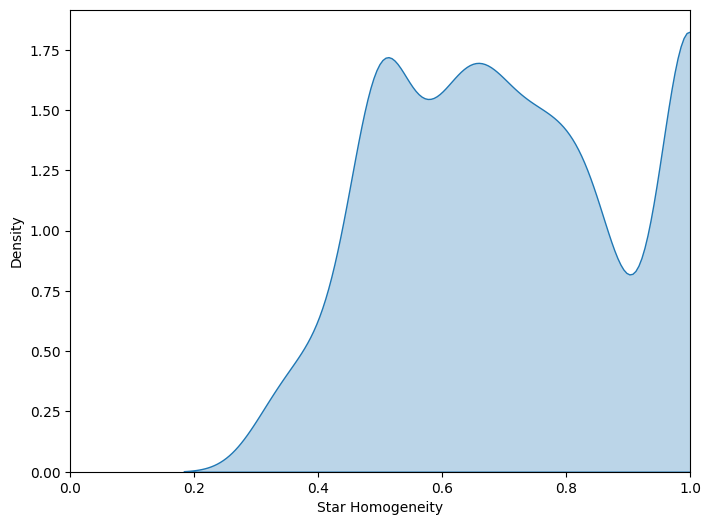

In [16]:
plot_kde(homs, 'Star Homogeneity')

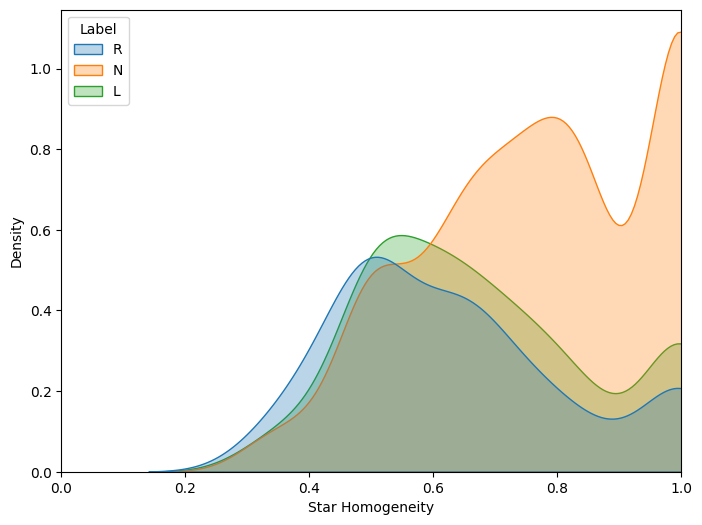

In [17]:
plot_kde(homs, 'Star Homogeneity', True)

### Exercises

**E1: Build a hypergraph from the Politics dataset using the provided function. Then, plot the distribution of nodes for each class (political leaning)**

In [18]:
def load_reddit_data(dataset_name, attributes=False, by_timestamp=False):
    if not by_timestamp:
        # res is an hypergraph
        res = hgx.Hypergraph()
        with open(f"icwsm2025/{dataset_name}-edges.txt") as f:
            for line in f:
                edge = [int(x) for x in line.strip().split()[1:]]
                res.add_edge(edge)
        if attributes:
            with open(f"icwsm2025/{dataset_name}-labels.csv") as f:
                labels = {}
                for line in f:
                    n, t, l = line.strip().split(',')
                    labels[int(n)] = l
                for n, l in labels.items():
                    if res.check_node(n):
                        res.set_meta(n, {'leaning': l})
    else:
        # res is a list of hypergraphs
        res = [hgx.Hypergraph(), hgx.Hypergraph(),
            hgx.Hypergraph(), hgx.Hypergraph(),
            hgx.Hypergraph()]
        with open(f"icwsm2025/{dataset_name}-edges.txt") as f:
            for line in f:
                line = line.strip().split()
                t = int(line[0])
                edge = [int(x) for x in line[1:]]
                res[t].add_edge(edge)
        if attributes:
            with open(f"icwsm2025/{dataset_name}-labels.csv") as f:
                for line in f:
                    n, t, l = line.strip().split(',')
                    if res[int(t)].check_node(int(n)):
                        res[int(t)].set_meta(int(n), {'leaning': l})
    return res

In [19]:
# E1 here

**E2. Compute star homogeneity values for all nodes in the hypergraph. Which class has an higher average star homogeneity?**

In [20]:
# E2 here

## High-order contagion

**High-order contagion** refers to the spread of information, behaviors, opinions, or diseases not just through one-to-one contact, but through **multi-way interactions**. In this scenario, groups play a crucial role in the spreading dynamics as the "contagion" can unroll with a different probability for each group size [2], and groups themselves can intensify phenomena like peer pressure [3].

> [2] Iacopini, I., Petri, G., Barrat, A., & Latora, V. (2019). *Simplicial models of social contagion.* Nature communications, 10(1), 2485.
>
> [3] R. Sahasrabuddhe, L. Neuhäuser, and R. Lambiotte. *Modelling non-linear consensus dynamics on hypergraphs*. In: Journal of Physics:
Complexity 2.2 (2021), p. 025006.

In this tutorial, we will explore how opinion diffusion dynamics change when considering *only pairwise interactions* versus when *group interactions* are also taken into account.

We will use the **multi-body consensus model (MCM)** from Sahasrabuddhe et al. [3] for the following reasons:
1. it combines homophily and group pressure/conformity social theories, extending them to hypergraphs;
2. it can be applied to both graphs and hypergraphs; and
3. by adjusting user involvement parameters, we can simulate various outcomes, including polarization, consensus toward the mean or a combination of both -- allowing us to explore diverse scenarios.

MCM models:
- The concept of **homophily**, which captures the tendency of like-minded individuals to interact [4];
- The concept of **conformity**, which is used to describe the tendency of an individual to align their beliefs to those of their peers and is usually affected by the reinforcing nature of shared opinions (peer pressure) [5].

> [4] M. McPherson, L. Smith-Lovin, and J. M. Cook. *Birds of a Feather: Homophily in Social Networks*. In: Annual Review of Sociology
27.Volume 27, 2001 (2001), pp. 415-444.
>
> [5] M. Sherif and C. I. Hovland. *Social judgment: Assimilation and
contrast effects in communication and attitude change*. Yale University Press, 1961.

### Implementation of the multi-body consensus model (MCM)

In [21]:
import copy
import math

import matplotlib.pyplot as plt
import numpy as np

import tqdm

ModuleNotFoundError: No module named 'tqdm'

In [ ]:
#
# Homophily function
# potentially, each node can have different parameters
# - high involvment Φₐ=0.10, Φᵣ=0.15
# - medium involvment Φₐ=0.15, Φᵣ=0.30
# - low involvment Φₐ=0.40, Φᵣ=0.80
#
def homophily(avg_dis, my_lambda=-1, theta_acc=0.15, theta_rej=0.30):
    # avg_dis will be very low if the opinion of node x
    # is close to the average opinion of its neighbors
    # in the same hyperedge
    if avg_dis <= theta_acc:
        return math.exp(my_lambda * avg_dis)
    # avg_dis will be very high if the opinion of node x
    # is far away to the average opinion of its neighbors
    # in the same hyperedge
    elif avg_dis >= theta_rej:
        return - math.exp(my_lambda * avg_dis)
    else:
        return 0

In [ ]:
#
# Conformity function
# potentially, each node can have different parameters
#
def conformity(avg_dis, delta=-5):
    return math.exp(delta * avg_dis)

In [ ]:
def simulate(h, initial_opinions, max_iter=3.0, step=0.01, theta_acc=0.15, theta_rej=0.30, verbose=True):
  """
    Reproduce the opinion change process from the paper
    "Modelling non-linear consensus dynamics on hypergraphs"
    https://iopscience.iop.org/article/10.1088/2632-072X/abcea3/meta
  """

  # initialize the memory of the simulation
  # it stores the initial opinion of each node
  # Dict[int, List[float]]
  opinion_history = {}

  for v in range(h.num_nodes()):
    opinion_history[v] = []

  # Save the initial opinions
  curr_opinions = [initial_opinions[v].item() for v in range(h.num_nodes())]
  next_opinions = [0.0] * h.num_nodes()

  # Storing the timesteps information
  timesteps = []

  # Simulate the diffusion process
  #while t < max_iter:
  for t in tqdm.tqdm(np.arange(0, max_iter, step)):
    verbose and print(f"Iteration {t}/{max_iter}")

    # Iterate over all nodes
    for v in h.get_nodes():

      # Initialize the gain of the node v
      gains = {he_id: 0.0 for he_id in h.get_edges()}

      # Iterate over all neighbors considering
      # a single hyperedge per time
      for he in h.get_incident_edges(v):
        avg_op = 0.0
        avg_neigh_op = 0.0

        neighbors = [n for n in he] #if n != v

        # If the node v is the only node in the hyperedge
        # then the gain is 0
        if len(neighbors) == 1:
          gains[he] = 0.0
          continue

        # Iterate over all neighbors of the node v in the hyperedge he
        for u in neighbors:
          # Sum up the nodes' opinions
          avg_op += curr_opinions[u]

          # We also store the avg opinion of the neighbors
          # of the node v excluding v itself
          if u != v:
            avg_neigh_op += curr_opinions[u]

        # Compute the average opinion of the neighbors in he
        avg_op /= len(neighbors)

        # And how much the opinion of the node v
        # differs from the average opinion of the he
        avg_dis_v = avg_op - curr_opinions[v]

        # Evaluate the homophily value
        homophily_v = homophily(abs(avg_dis_v), theta_acc=theta_acc, theta_rej=theta_rej)

        # Evaluate the conformity value
        conformity_v = 0.0
        # Compute the average opinion of the he, excluding v
        avg_neigh_op /= (len(neighbors) - 1)

        # Here we evaluate how much a node u differs from the average opinion
        # of the hyperedge, without considering the opinion of the node v
        for u in neighbors:
          avg_dis = avg_neigh_op - curr_opinions[u]
          conformity_u = conformity(abs(avg_dis)) * (curr_opinions[u] - curr_opinions[v])
          conformity_v += conformity_u

        # Compute the gain from each hyperedge
        gain = conformity_v * homophily_v

        # Store the value
        gains[he] = gain

      # Aggregate the gains from all hyperedges
      gain = sum(list(gains.values()))

      # update opinion
      next_op_v = curr_opinions[v] + step * gain

      if next_op_v > 1.0:
        next_op_v = 1.0
      elif next_op_v < 0.0:
        next_op_v = 0.0

      next_opinions[v] = next_op_v

      # Store the current opinion vector
      opinion_history[v].append(next_op_v)

    # update the time
    timesteps.append(t)

    # verify convergence
    opinion_diff = np.array(next_opinions) - np.array(curr_opinions)
    if abs(np.std(opinion_diff)) < 0.0005:
      print(f"convergence reached at {t}/{max_iter} iteration")
      break

    # update the current opinion vector
    curr_opinions = copy.deepcopy(next_opinions)

  return opinion_history, timesteps

### Utils

In [ ]:
def get_fraction_extreme_opinions(opinions, thr_pos, thr_neg):
  """
    Returns the fraction of nodes in the simulation who have extreme opinions,
    i.e., opinion >= thr_pos or opinion <= thr_neg
  """
  n_nodes = len(opinions)
  timesteps = list(opinions.values())[0]

  fraction_positives = [0.0] * len(timesteps)
  fraction_negatives = [0.0] * len(timesteps)

  for t in range(len(timesteps)):
    n_pos = 0
    n_neg = 0

    for v_ops in opinions.values():
      v_op = v_ops[t]

      if v_op >= thr_pos:
        n_pos += 1
      elif v_op <= thr_neg:
        n_neg += 1

    fraction_positives[t] = n_pos / n_nodes
    fraction_negatives[t] = n_neg / n_nodes

  return fraction_positives, fraction_negatives

In [ ]:
from itertools import combinations

def my_clique(hg):
  """
    Converts a hypergraph into its clique representation
    by reducing each hyperedge of size greater than two
    into all possible pairwise edges.
  """
  clique = hgx.Hypergraph()

  clique.add_nodes(hg.get_nodes())

  for he in hg.get_edges():
    if len(he) <= 2:
      clique.add_edge(he)
    else:
      edges = list(combinations(he, 2))
      clique.add_edges(edges)

  return clique

### Simulation

Let's consider our example hypergraph `h`.

In [ ]:
print(h)

Hypergraph with 1000 nodes and 1900 edges.
Distribution of hyperedge sizes: {2: 1000, 3: 500, 4: 300, 5: 100}


Now we generate its **clique representation**.

**Highlight**: The **clique graph** of a hypergraph H is the graph whose vertices are the vertices of H and where two distinct vertices form an edge if and only if they are in the same hyperedge of H.

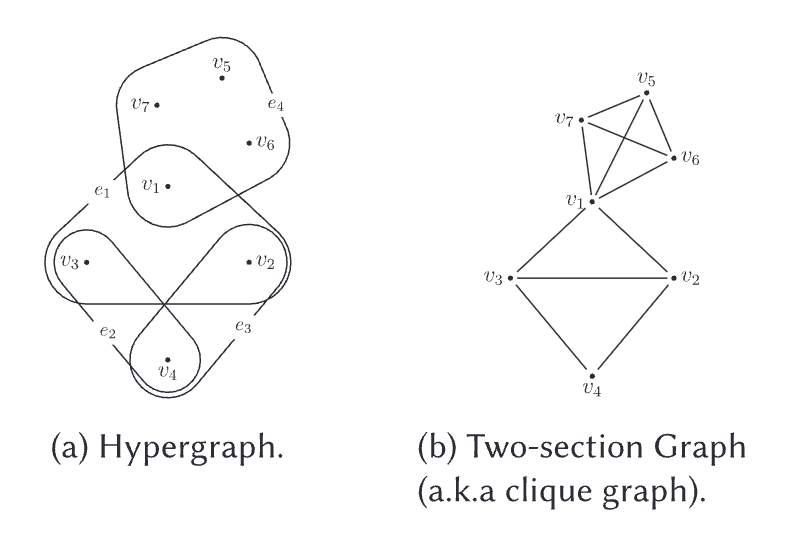


In [ ]:
clique = my_clique(h)

In [ ]:
print(clique)

Hypergraph with 1000 nodes and 5282 edges.
Distribution of hyperedge sizes: {2: 5282}


We initialize the opinion of each node by assigning a random number between [0, 1]...

In [ ]:
# assign a random opinion between [0, 1]
initial_opinions = np.random.random(h.num_nodes())

... and run the simulation.

In [ ]:
# simulation on the hypergraph
opinion_history, timesteps = simulate(
    h,
    initial_opinions,
    max_iter=3.0,
    theta_acc=0.15,
    theta_rej=0.30,
    verbose=False
  )

 86%|█████████████████████████████████████████████████████████████▎         | 259/300 [00:27<00:04,  9.36it/s]

convergence reached at 2.59/3.0 iteration


In [ ]:
# simulation on the clique graph
opinion_history_clique, timesteps_clique = simulate(
    clique,
    initial_opinions,
    max_iter=3.0,
    theta_acc=0.15,
    theta_rej=0.30,
    verbose=False
  )

 52%|████████████████████████████████████▋                                  | 155/300 [00:50<00:47,  3.08it/s]

convergence reached at 1.55/3.0 iteration


Now we plot the opinion trend of each node over time.

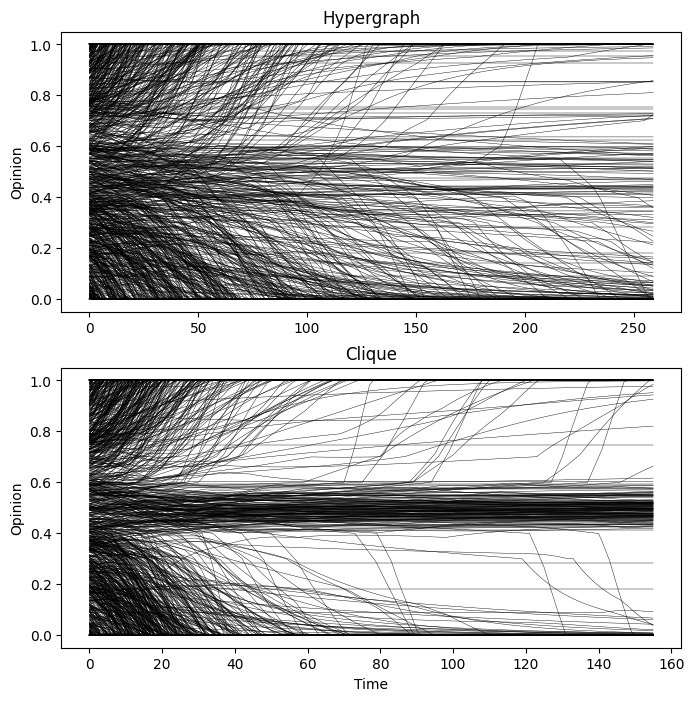

In [ ]:
# plot the opinion trend
fig, (ax_h, ax_c) = plt.subplots(2, figsize=(8, 8))

for v in range(h.num_nodes()):
  ax_h.plot(range(len(timesteps)), opinion_history[v], color='black', linewidth=.3)

for v in range(h.num_nodes()):
  ax_c.plot(range(len(timesteps_clique)), opinion_history_clique[v], color='black', linewidth=.3)

ax_h.set(title='Hypergraph', ylabel='Opinion')
ax_c.set(title='Clique', xlabel='Time', ylabel='Opinion')

plt.show()

Let's evaluate how the fraction of extreme opinions differs in the two scenarios.

In [ ]:
thr_pos = 0.7
thr_neg = 0.3

# hypergraph
fraction_positives, fraction_negatives = get_fraction_extreme_opinions(opinion_history, thr_pos, thr_neg)
#clique
fraction_positives_clique, fraction_negatives_clique = get_fraction_extreme_opinions(opinion_history_clique, thr_pos, thr_neg)

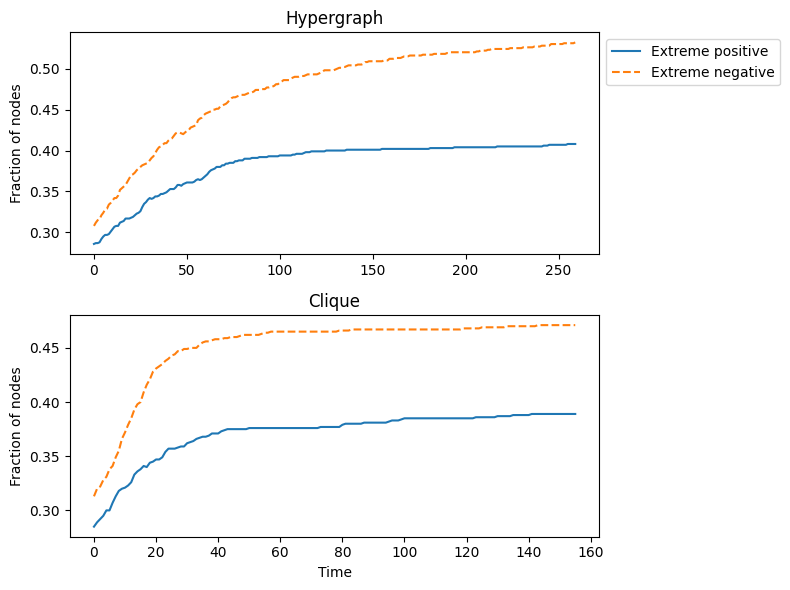

In [ ]:
# plot the fraction of extreme opinions
fig, (ax_h, ax_c) = plt.subplots(2, figsize=(8, 6))

ax_h.plot(range(len(timesteps)), fraction_positives)
ax_h.plot(range(len(timesteps)), fraction_negatives, '--')
ax_h.legend(
    ['Extreme positive', 'Extreme negative'],
    bbox_to_anchor=(1., 1.0)
)

ax_c.plot(range(len(timesteps_clique)), fraction_positives_clique)
ax_c.plot(range(len(timesteps_clique)), fraction_negatives_clique, '--')

ax_h.set(title='Hypergraph', ylabel='Fraction of nodes')
ax_c.set(title='Clique', xlabel='Time', ylabel='Fraction of nodes')

plt.tight_layout()
plt.show()

### Exercises

**E1: Build a hypergraph from the Politics dataset using the provided function. Simulate the MCM model, and visualize the opinion trend and the fraction of extreme opinions.**

Initialize the opinion vector based on the political leaning of the users, assigning a random value between:
- 0.7 and 1 if the user is *'antitrump'*;
- 0.0 and 0.3 if the user is *'protrump'*;
- 0.35 and 0.65 if the opinion is *'neutral'*.

In [ ]:
def load_reddit_data(dataset_name, attributes=False, by_timestamp=False):
  if not by_timestamp:

    user2id = {}
    nid = 0

    # res is an hypergraph
    res = hgx.Hypergraph()

    with open(f"icwsm2025/{dataset_name}-edges.txt") as f:
      for line in f:
        edge = [int(x) for x in line.strip().split()[1:]]

        for n in edge:
          if n not in user2id:
            user2id[n] = nid
            nid += 1

        edge_to_add = [user2id[n] for n in edge]
        res.add_edge(edge_to_add)
    if attributes:
      with open(f"icwsm2025/{dataset_name}-labels.csv") as f:
        labels = {}
        for line in f:
          n, t, l = line.strip().split(',')
          if int(n) not in user2id:
            continue
          labels[user2id[int(n)]] = l
        for n, l in labels.items():
          if res.check_node(n):
            res.set_meta(n, {'leaning': l})
  else:
      # res is a list of hypergraphs
      res = [hgx.Hypergraph(), hgx.Hypergraph(),
           hgx.Hypergraph(), hgx.Hypergraph(),
           hgx.Hypergraph()]
      with open(f"icwsm2025/{dataset_name}-edges.txt") as f:
        for line in f:
          line = line.strip().split()
          t = int(line[0])
          edge = [int(x) for x in line[1:]]
          res[t].add_edge(edge)
      if attributes:
        with open(f"icwsm2025/{dataset_name}-labels.csv") as f:
          for line in f:
            n, t, l = line.strip().split(',')
            if res[int(t)].check_node(int(n)):
              res[int(t)].set_meta(int(n), {'leaning': l})
  return res

In [ ]:
# E1 here

**E2: Simulate the MCM model using different parameters. How do the opinion trend and the fraction of extreme opinions vary?**


In [ ]:
# - high involvment Φₐ=0.10, Φᵣ=0.15
# - medium involvment Φₐ=0.15, Φᵣ=0.30
# - low involvment Φₐ=0.40, Φᵣ=0.80

In [ ]:
# E2 here

 57%|████████████████████████████████████████▋                              | 172/300 [03:53<02:53,  1.36s/it]

convergence reached at 1.72/3.0 iteration
